In [717]:
# Importing Modules and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

In [718]:
#Loading Dataset

def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data=json.loads(file.read())
    return Json_data

In [719]:
data=load_doc('intents.json')

In [720]:
# Extracting questions from dataset into pandas dataframe

def frame_data(feat_1,feat_2,is_pattern):
    is_pattern=is_pattern
    df=pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w=pattern
                df_to_append=pd.Series([w,intent['tag']],index=df.columns)
                df=df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w=response
                df_to_append=pd.Series([w,intent['tag']],index=df.columns)
                df=df.append(df_to_append,ignore_index=True)
    return df

In [721]:
df1=frame_data('questions','labels',True)
print(df1.shape)
df1.head()

(422, 2)


,questions,labels
0,Hi,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [722]:
df1.labels.value_counts(sort=False)

greeting                9
goodbye                12
creator                16
name                   13
hours                  17
number                 15
course                 17
B.Tech.                10
M.Tech                 10
Ph.D.                  10
fees                   14
location               14
hostel                 22
event                  11
document               13
floors                  7
syllabus               12
library                12
infrastructure          3
canteen                10
menu                    5
placement               8
applied science hod     7
csehod                  6
ecehod                  6
ithod                   6
architecture hod        6
mechhod                 6
managementhod           6
aihod                   6
Chancellor              8
sem                    11
admission               6
facilities              5
college intake          9
uniform                 9
committee               6
random                  3
vacation    

In [723]:
# Extracting responses from dataset into a pandas dataframe

df2=frame_data('response','labels',False) 
print(df2.shape)
df2.head()

(59, 2)


,response,labels
0,Hello!,greeting
1,Good to see you again!,greeting
2,"Hi there, how can I help?",greeting
3,Sad to see you go :(,goodbye
4,Talk to you later,goodbye


In [724]:
"""" Text Pre Processing
      
    Tokenisation and Lemmatization


Tokenisation is the cat of splitting a text corpus into constituent words-(ie splitting a phrase,sentence,paragraph or an entire text document into smaller units such as individual words or terms .Each of this smaller units is called a token. Tokenisation can be done manually by splitting based on white space or by using dedicated tools in libraries such as NLTK

Lemmatization is a common normalisation technique in text pre-processing.In lemmatisation words are replaced by their root forms or words with similar context.Another text normalisation technique similar to this is called stemming.This is often done alongside manual tokanisation so as to yiels useful tokens

The function below is used to tokenise and lemmatize our corpus"""

lemmatizer=WordNetLemmatizer()
vocab=Counter()
labels=[]
def tokenizer(entry):
    tokens=entry.split()
    re_punc=re.compile('[%s]'% re.escape(string.punctuation))
    tokens=[re_punc.sub('',w) for w in tokens]
    tokens=[word for word in tokens if word.isalpha()]
    tokens=[lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens=[word.lower() for word in tokens if len(word)>1]
    return tokens


In [725]:
""" Removing Stop Words
    Its also a good practice to remove stop words from tokens so as to avoid misleading the model .Stop words are words that do not contribute to deeper meaning of phrase--definite and indefinite articles,pronouns and conjunctions to mention a few .With the NLTK Library ,filtering out stop words is easy , and you can also add the words that you feel should be a stop word into the predefined sets of words in the library"""

def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords=[]
    for entry in df[feature]:
        tokens=tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature]=doc_without_stopwords
    return

In [726]:
""""Vocabulary Building
    Once we remove the stop words, the text is becoming cleaner,and atleast halfway ready for modelling .Our next step is to build a vocabulary,which is a set of words in a given dataset,after the removal of stop words.This will come in very handy at the time of adat encoding"""

def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens=tokenizer(entry)
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return

In [727]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [728]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [729]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\HP\AppData\Roami

True

In [730]:
create_vocab(tokenizer,df1,'questions')

In [731]:
remove_stop_words(tokenizer,df1,'questions')

In [732]:
print(vocab.most_common(20))

[('is', 84), ('college', 73), ('what', 54), ('hod', 49), ('the', 45), ('of', 40), ('you', 35), ('how', 31), ('in', 31), ('are', 25), ('name', 22), ('hostel', 22), ('who', 19), ('where', 18), ('to', 17), ('fee', 16), ('for', 16), ('available', 15), ('facility', 15), ('can', 14)]


In [733]:
vocab_size=len(vocab)
vocab_size

252

In [734]:
test_list=list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list


['how many btech stream',
 'what is the name of vice chancellor',
 'how many mtech stream',
 'how many phd stream',
 'what is the process of admission',
 'who is ai hod',
 'who is applied science hod',
 'who is architecture department hod',
 'food facility',
 'max number of student',
 'what are the different committe in college',
 'list of course',
 'what is the name of your developer',
 'who is cse hod',
 'document to bring',
 'who is ece hod',
 'event organised',
 'what facility college provide',
 'information about fee',
 'size of campus',
 'cya',
 'hi',
 'hod',
 'hostel facility',
 'timing of college',
 'how is college infrastructure',
 'who is it hod',
 'is there any library',
 'where is the college located',
 'who is management hod',
 'who is mechanical hod',
 'food menu',
 'nearest metro station',
 'name',
 'more info',
 'what is college placement',
 'ragging',
 'love you',
 'okk',
 'exam date',
 'syllabus for it',
 'what can you do',
 'dtc bus route',
 'college dress code',
 'h

In [735]:
test_index=[]
for i,_ in enumerate(test_list):
    idx=df1[df1.questions==test_list[i]].index[0]
    test_index.append(idx)
test_index

[99,
 309,
 109,
 119,
 328,
 303,
 260,
 285,
 237,
 339,
 357,
 82,
 21,
 267,
 190,
 273,
 179,
 334,
 129,
 203,
 9,
 0,
 402,
 157,
 50,
 234,
 279,
 222,
 143,
 297,
 291,
 247,
 414,
 37,
 67,
 252,
 394,
 363,
 376,
 317,
 210,
 388,
 405,
 348,
 366]

In [736]:
train_index=[i for i in df1.index if i not in test_index]


In [737]:
' '.join(list(vocab.keys()))

'hi how are you is anyone there hello good day whats up ya heyy whatsup cya see bye later goodbye am leaving have talk to tyyl got go gtg what the name of your developer creator who created made by whom create designed do called should call this chatting taking timing college working when guy open hour operation about on saturday tell something come attend my time more info contact telephone number no phone can get list course offered in igdtuw offer branch available at me many btech stream field type mtech phd information fee per semester each year much for first where located address reach location wheres hostel facility servive doe provide any capacity far from distance big between and event organised conducted held function document bring needed admision admission during required which need size campus building floor tall syllabus it technology timetable next lecture computer science holiday ece library book infrastructure food canteen cafetaria menu we placement company visit aver

In [738]:
"""Encoding and Decoding
  Now that we have vocabulary of words in dataset,each of patterns can be encoded into numerical feature for modelling--using any of the comment text encoding techniques--count vectorizer,term frequency-inverse document frequency(TF-IDF),hashing etc. Using tensorflow.keras text_to_sequence,we can encode each pattern corpus to vectorize a text corpus by turning each text into a either sequence of integers(each integer being the index of token in a dictionary)or into a vector where a coefficient for each token could be binary,based on word count which is based on TF-IDF.The resulting vectors will be postpadded with zeroes so as to equal the length of vector  """

def encoder(df,feature):
    t=Tokenizer()
    entries=[entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size=len(t.word_index)+1
    entries=[entry for entry in df[feature]]
    max_length=max([len(s.split())for s in entries])
    encoded=t.texts_to_sequences(entries)
    padded=pad_sequences(encoded,maxlen=max_length,padding='post')
    return padded,vocab_size

In [739]:
x,vocab_size=encoder(df1,'questions')

In [740]:
vocab_size

253

In [741]:
df_encoded=pd.DataFrame(x)

In [742]:
df_encoded['labels']=df1.labels
df_encoded.head()

,0,1,2,3,4,5,6,7,8,labels
0,155,0,0,0,0,0,0,0,0,greeting
1,8,10,7,0,0,0,0,0,0,greeting
2,1,156,31,0,0,0,0,0,0,greeting
3,157,0,0,0,0,0,0,0,0,greeting
4,90,91,0,0,0,0,0,0,0,greeting


In [743]:
for i in range(0,2):
    dt=[0]*16
    dt.append('confused')
    dt=[dt]
    pd.DataFrame(dt).rename(columns={16:'labels'})
    df_encoded=df_encoded.append(pd.DataFrame(dt).rename(columns={16:'labels'}),ignore_index=True)

In [744]:
df_encoded.tail()

,0,1,2,3,4,5,6,7,8,labels,9,10,11,12,13,14,15
419,154,51,58,0,0,0,0,0,0,metro,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,51,0,0,0,0,0,0,0,0,metro,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,51,58,154,0,0,0,0,0,0,metro,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,0,0,0,0,0,0,0,0,0,confused,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423,0,0,0,0,0,0,0,0,0,confused,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [745]:
df_encoded.fillna(0,inplace=True)

In [746]:
# Train Test Split

train_index.append(422)
test_index.append(423)

In [747]:
#convert dataset to machine readable form using label encoding
from sklearn.preprocessing import LabelEncoder
label_enc=LabelEncoder()

In [748]:
labl=label_enc.fit_transform(df_encoded.labels)
labl

array([22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 20,
       20, 20, 20, 20, 20, 20, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 28, 28, 28, 28

In [749]:
# Encodin ['label'] into machine readable form

mapper={}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key]=labl[index]
mapper

{'greeting': 22,
 'goodbye': 21,
 'creator': 13,
 'name': 34,
 'hours': 25,
 'number': 35,
 'course': 12,
 'B.Tech.': 0,
 'M.Tech': 2,
 'Ph.D.': 3,
 'fees': 19,
 'location': 29,
 'hostel': 24,
 'event': 17,
 'document': 15,
 'floors': 20,
 'syllabus': 41,
 'library': 28,
 'infrastructure': 26,
 'canteen': 8,
 'menu': 32,
 'placement': 36,
 'applied science hod': 6,
 'csehod': 14,
 'ecehod': 16,
 'ithod': 27,
 'architecture hod': 7,
 'mechhod': 31,
 'managementhod': 30,
 'aihod': 5,
 'Chancellor': 1,
 'sem': 40,
 'admission': 4,
 'facilities': 18,
 'college intake': 9,
 'uniform': 44,
 'committee': 10,
 'random': 38,
 'vacation': 45,
 'salutaion': 39,
 'task': 42,
 'ragging': 37,
 'hod': 23,
 'transport': 43,
 'metro': 33,
 'confused': 11}

In [750]:
# Mapping encoded label to response dataset and saving it as csv for future use
df2.labels=df2.labels.map(mapper)

In [751]:
df2.dropna(inplace=True)

In [752]:
df2.labels=df2.labels.astype({'labels':'int32'})

In [753]:
df2.head()

,response,labels
0,Hello!,22
1,Good to see you again!,22
2,"Hi there, how can I help?",22
3,Sad to see you go :(,21
4,Talk to you later,21


In [754]:
df2.to_csv('response.csv',index=False)

In [755]:
"""" Data Splitting
    With the data encoded, we can now split it into training and testing sets.The training set will be used to train a model while the testing set will be used for evaluating its performance on unseen data. This can be done using a stratified approach,wherby of pattern in tags are well represented in  testing sets"""

train=df_encoded.loc[train_index]
test=df_encoded.loc[test_index]

In [756]:
x_train=train.drop(columns=['labels'],axis=1)
y_train=train.labels
x_test=test.drop(columns=['labels'],axis=1)
y_test=test.labels

In [757]:
y_train=pd.get_dummies(y_train).values
y_test=pd.get_dummies(y_test).values

In [758]:
y_train[0].shape,y_test[0].shape

((46,), (46,))

In [759]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(378, 16) (378, 46) (46, 16) (46, 46)


In [760]:
max_length=x_train.shape[1]
output=46

In [761]:
max_length

16

In [762]:
"""" Model architecture
    The most common approach to building a model on sequence input is to use a reinforcement learning model-we'll use a long-short-term-memory(LSTM) architecture due to its state-of-the-art performance.The choice for this project is Convolusional Neural Network(CNN)+an embedding layer+fully connected layer.
    
    A word embedding is a method of representing text in which each word in vocabulary is represented by real-valued vector in a high-dimensional space.These vectors are learned in such a way that words which have a similar meaning  will have similar representations in vector space..This has been proven as a better representation of text than normal classical method like bag-of-words,where relationship between words or tokens are ignored or forced in bigram and trigram approaches.These vectors are learned and updated during the model training."""

early_stopping=EarlyStopping(monitor='val_loss',patience=10)
checkpoint=ModelCheckpoint("model-v1.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                           verbrose=2

)
reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=3,verbose=1,min_delta=0.0001)
callbacks=[early_stopping,checkpoint,reduce_lr]

In [763]:
def define_model(vocab_size,max_length):
    model=Sequential()
    model.add(Embedding(vocab_size,600,input_length=max_length))
    model.add(Conv1D(filters=64,kernel_size=4,activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Flatten())
    model.add(Dense(output,activation='softmax'))

    #compile networks
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    #summarise defined model
    model.summary()
    plot_model(model,to_file='model.png',show_shapes=True)
    return model

In [764]:
# Define model
model=define_model(vocab_size,max_length)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 16, 600)           151800    
                                                                 
 conv1d_13 (Conv1D)          (None, 13, 64)            153664    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 46)                2990      
                                                                 
Total params: 308,454
Trainable params: 308,454
Non-trainable params: 0
_______________________________________________

In [765]:
""" As seen in the code snippet above, the vector output of embedding layer is 600 and followed by a 1-Dimensional convolutional layer using using 64 filters with kernel size of 4,each using a ReLu fuction. Then,a 1-dimensional max pooling layer with a pool size of 8.These vectors are fattened(transposed to a single row of vectors) for a fully connected layer before compiling it with Adam optimiser.This parameters are a result of self iterative process, with the aim being to get best model architecture for dataset at hand. The model summary can also be seen"""



' As seen in the code snippet above, the vector output of embedding layer is 600 and followed by a 1-Dimensional convolutional layer using using 64 filters with kernel size of 4,each using a ReLu fuction. Then,a 1-dimensional max pooling layer with a pool size of 8.These vectors are fattened(transposed to a single row of vectors) for a fully connected layer before compiling it with Adam optimiser.This parameters are a result of self iterative process, with the aim being to get best model architecture for dataset at hand. The model summary can also be seen'

In [766]:
# Training the model
history=model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test),callbacks=callbacks)


Epoch 1/50
12/12 [==============================] - 1s 23ms/step - loss: 3.7944 - accuracy: 0.0767 - val_loss: 3.7556 - val_accuracy: 0.1087 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 0s 14ms/step - loss: 3.6109 - accuracy: 0.3042 - val_loss: 3.6578 - val_accuracy: 0.1957 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 0s 18ms/step - loss: 3.3928 - accuracy: 0.3915 - val_loss: 3.5236 - val_accuracy: 0.2609 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 0s 14ms/step - loss: 3.1063 - accuracy: 0.4603 - val_loss: 3.3363 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 0s 19ms/step - loss: 2.7428 - accuracy: 0.5556 - val_loss: 3.0631 - val_accuracy: 0.3261 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 0s 16ms/step - loss: 2.3144 - accuracy: 0.6376 - val_loss: 2.7596 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - 0s 16ms/step - loss: 1.8

Accuracy of Model: 84.78260636329651 %


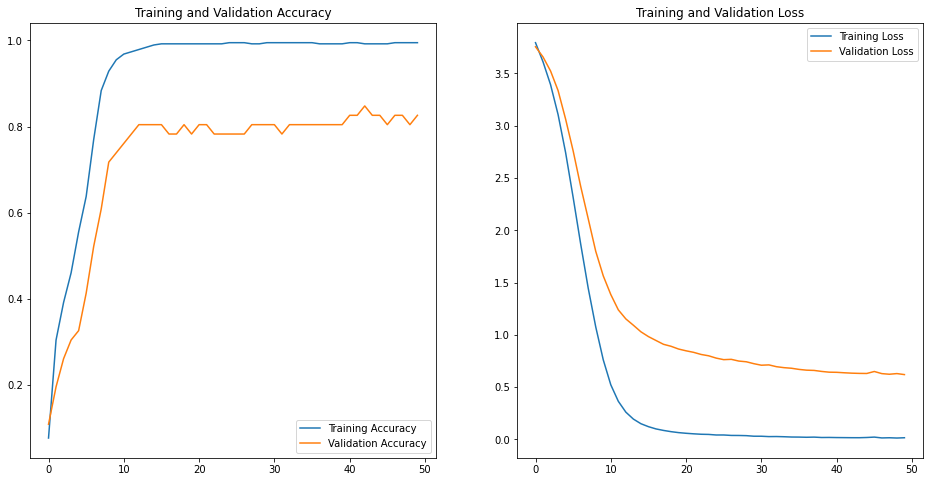

In [767]:
print("Accuracy of Model:", max(history.history['val_accuracy'])*100,"%")
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(loss,label="Training Loss")
plt.plot(val_loss,label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()